<a href="https://colab.research.google.com/github/achillesposiedon/GAN/blob/master/CIFAR_10GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
!pip install -q imageio

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [3]:
import keras
from keras.datasets import cifar10

(train1,label),(test,labeltest)=cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 13s 0us/step


In [4]:
print(train1.shape)
print(label.shape)
print(test.shape)
print(labeltest.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [0]:
train1=train1.reshape(50000,32,32,3).astype('float32')
train1=(train1-127.5)/127.5 #range (-1,1)

test=test.reshape(10000,32,32,3).astype('float32')
test=(test-127.5)/127.5 #range (-1,1)

batchsize=256
buffersize=50000

# Batch and shuffle the data
traindata = tf.data.Dataset.from_tensor_slices(train1).shuffle(buffersize).batch(batchsize)



In [0]:
def generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

In [7]:
g=generator()
g.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


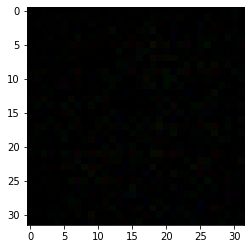

In [8]:
#check generator work

noise=tf.random.normal([3,100])
img=g(noise,training=False)
plt.imshow(img[0,:,:,:])

In [0]:
def discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(3, 3), padding='same',
                                     input_shape=[32, 32, 3]),)
    
    model.add(layers.Conv2D(32, (5, 5), strides=(3, 3), padding='same',
                                     ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    #model.add(layers.Conv2D(64, (5, 5), strides=(3, 3), padding='same'))
    #model.add(layers.Conv2D(64, (5, 5), strides=(3, 3), padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))    
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1024))
    model.add(layers.Dense(512))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1))

    return model

In [40]:
d=discriminator()
d.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 11, 11, 32)        2432      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 4, 4, 32)          25632     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 2, 2, 32)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2, 2, 32)          0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 1, 32)          0         
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 1, 1, 32)        

In [11]:
decision=d(img)
print(decision)

tf.Tensor(
[[0.00359796]
 [0.00379451]
 [0.00199169]], shape=(3, 1), dtype=float32)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(realimg, genimg):
    real_loss = cross_entropy(tf.ones_like(realimg), realimg)
    fake_loss = cross_entropy(tf.zeros_like(genimg), genimg)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(genimg):
    return cross_entropy(tf.ones_like(genimg), genimg)

goptimizer=tf.keras.optimizers.Adam(1e-4)
doptimizer=tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=goptimizer,
                                 discriminator_optimizer=doptimizer,
                                 generator=g,
                                 discriminator=d)

epochs=50
noisesize=100
numgen=12

seed=tf.random.normal([numgen,noisesize])

@tf.function #for graph
def trainhist(images):
    noise = tf.random.normal([batchsize, noisesize])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = g(noise, training=True)

      real_output = d(images, training=True)
      fake_output = d(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, g.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, d.trainable_variables)

    goptimizer.apply_gradients(zip(gradients_of_generator, g.trainable_variables))
    doptimizer.apply_gradients(zip(gradients_of_discriminator, d.trainable_variables))


def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      trainhist(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(g,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(g,
                           epochs,
                           seed)


def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

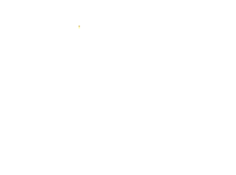

In [41]:
train(traindata, epochs=100)